# 3) POS Pattern Frequency (Adj+N, V+N, etc.)

This notebook is part of **Applied NLP – Session 2: Phrases & Collocations**.

Overview:
- Analyze grammatical patterns in bigrams using Part-of-Speech (POS) tagging.
- Identify common POS patterns like ADJ+NOUN, VERB+NOUN, NOUN+NOUN across two works by the same author.
- Visualize the distribution of POS patterns to understand syntactic phrase structure.

Learning objectives:
- Apply spaCy POS tagging to tokenized text for grammatical analysis.
- Compute and compare POS bigram patterns across literary texts.
- Visualize syntactic patterns to identify stylistic features.
- Understand how preprocessing choices (stopwords, filtering) affect syntactic analysis.

Quick start:
1. Edit the `CONFIG` dictionary in the next code cell to point to your two plain-text books.
2. (Optional) Toggle `use_stopwords` to remove common function words.
3. Run cells from top to bottom. The main outputs are saved to `../results/`.
4. Ensure `en_core_web_sm` spaCy model is installed (included in requirements.txt).

Prerequisites:
- A Python environment with requirements.txt packages installed (pandas, matplotlib, spacy).
- spaCy English model: `en_core_web_sm` (should be installed via requirements.txt).
- The text files for the two works placed in `../data/`.

Notes and tips:
- The notebook uses the same robust preprocessing as notebooks 1-2 (strip_gutenberg, normalize quotes, etc.).
- POS tagging can be slow on large texts; consider slicing tokens or processing in chunks.
- Common patterns: ADJ+NOUN (descriptive phrases), VERB+NOUN (action phrases), NOUN+NOUN (compounds).
- Compare patterns between your two books to see if syntactic style differs.
- For non-English texts, change the spaCy model in the CONFIG or POS tagging cell (e.g., `de_core_news_sm` for German).

**Goal:** Identify and visualize the most frequent Part-of-Speech bigram patterns (e.g., ADJ+NOUN, VERB+NOUN) in your two selected works.


## 0. Setup & Configuration

- Fill the `CONFIG` paths for your two books (plain text).
- Toggle stopwords and thresholds as needed.


In [5]:
# ===== Imports & Config =====
import re, os, math, json, collections
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.grid"] = True

CONFIG = {
    "book1_path": "../data/Homer_Iliad_book.txt",  # <-- change
    "book2_path": "../data/Homer_Odyssey_book.txt",  # <-- change
    "language": "en",                # e.g. 'en','de','ru','el'
    "use_stopwords": False,          # toggle
    "min_ngram_count": 5,            # threshold (where applicable)
    "top_k": 20                      # top items to show
}

# Unicode-aware token regex: words with optional internal ' or -
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)

# Optional: supply your own stopwords set per language
STOPWORDS = set()


## 1. Load & Normalize Text

- Fix hyphenated line breaks (e.g., end-of-line hyphens).
- Normalize whitespace.
- Lowercase consistently.

Our books are a part of Project Gutenberg, which means there are some extra texts in each txt file to be cleaned.

In [6]:
# --- Robust Project Gutenberg boilerplate stripper --------------------------
_GB_START_MARKERS = [
    r"\*\*\*\s*----------------------------------------------------------------------",   # modern
    r"START OF (THIS|THE) PROJECT GUTENBERG EBOOK",             # fallback
    r"End of the Project Gutenberg(?:'s)? Etext",               # very old variants sometimes inverted
]
_GB_END_MARKERS = [
    r"\*\*\*\s*----------------------------------------------------------------------",      # modern
    r"END OF (THIS|THE) PROJECT GUTENBERG EBOOK",                # fallback
    r"End of Project Gutenberg(?:'s)? (?:Etext|eBook)",          # older variants
    r"\*\*\*\s*END: FULL LICENSE\s*\*\*\*",                      # license block end (older)
]

# Chapters (heuristic fallback if markers missing; English-centric but works often)
_CHAPTER_HINTS = [
    r"^\s*chapter\s+[ivxlcdm0-9]+[\.\: ]",   # CHAPTER I / Chapter 1
    r"^\s*book\s+[ivxlcdm0-9]+[\.\: ]",      # BOOK I etc.
    r"^\s*part\s+[ivxlcdm0-9]+[\.\: ]",
]

def strip_gutenberg(text: str) -> str:
    """
    Returns text between Gutenberg START and END markers (case-insensitive).
    If markers aren't found, heuristically trims to first chapter-like heading.
    Works for most EN/DE/RU/EL releases since headers are in English.
    """
    t = text.replace("\ufeff", "")  # strip BOM if present

    # Find START
    start_idx = None
    for pat in _GB_START_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            # start AFTER the matched line
            start_idx = t.find("\n", m.end())
            if start_idx == -1:
                start_idx = m.end()
            break

    # Find END
    end_idx = None
    for pat in _GB_END_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            # end BEFORE the matched line
            end_idx = m.start()
            break

    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        core = t[start_idx:end_idx]
    else:
        # Fallback: try to start at first chapter-like heading
        core = t
        for pat in _CHAPTER_HINTS:
            m = re.search(pat, core, flags=re.IGNORECASE | re.MULTILINE)
            if m:
                core = core[m.start():]
                break
        # And trim off the standard license tail if present
        for pat in _GB_END_MARKERS:
            m = re.search(pat, core, flags=re.IGNORECASE)
            if m:
                core = core[:m.start()]
                break

    # Remove license/contact blocks that sometimes sneak inside
    core = re.sub(r"\n\s*End of the Project Gutenberg.*", "", core, flags=re.IGNORECASE)
    core = re.sub(r"\*\*\*\s*START: FULL LICENSE\s*\*\*\*.*", "", core, flags=re.IGNORECASE | re.DOTALL)

    # Clean leftover cruft: URLs, repeated separators
    core = re.sub(r"https?://\S+", "", core)
    core = re.sub(r"[ \t]+\n", "\n", core)   # trailing spaces before newline
    core = re.sub(r"\n{3,}", "\n\n", core)   # collapse big blank blocks
    return core.strip()


In [7]:
def load_text(p: str) -> str:
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def normalize_text(t: str) -> str:
    # 1) strip Gutenberg header/footer FIRST
    t = strip_gutenberg(t)
    # 2) join hyphenated line breaks (e.g., "won-\nderful")
    t = re.sub(r"-\s*\n", "", t)
    # 3) normalize whitespace
    t = re.sub(r"\s+", " ", t)
    return t

text1 = normalize_text(load_text(CONFIG["book1_path"]))
text2 = normalize_text(load_text(CONFIG["book2_path"]))

tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())

if CONFIG["use_stopwords"]:
    tokens1 = [t for t in tokens1 if t not in STOPWORDS]
    tokens2 = [t for t in tokens2 if t not in STOPWORDS]

tokens = tokens1 + tokens2

len(tokens1), len(tokens2), len(tokens)

len(tokens), tokens[:12]


(269830,
 ['provided',
  'by',
  'the',
  'internet',
  'classics',
  'archive',
  'see',
  'bottom',
  'for',
  'copyright',
  'available',
  'online'])

## 2. POS Tagging Setup

Uses spaCy. For English: `en_core_web_sm`. For other languages, switch to an appropriate model. `en_core_web_sm` should be downloaded for you if you followed the requirements.txt requirements.


In [8]:
import spacy
# Change model as needed (e.g., 'de_core_news_sm', 'ru_core_news_sm')
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 3_000_000

def extract_pos_patterns(token_list, nlp_model):
    """Extract POS bigram patterns from a list of tokens."""
    doc = nlp_model(" ".join(token_list))
    pairs = []
    for i in range(len(doc)-1):
        a, b = doc[i], doc[i+1]
        if a.is_alpha and b.is_alpha:
            pairs.append(f"{a.pos_}+{b.pos_}")
    return Counter(pairs)

# Combined corpus POS patterns
print("Analyzing combined corpus...")
pat_counts_combined = extract_pos_patterns(tokens, nlp)
pos_df_combined = (pd.DataFrame(pat_counts_combined.items(), columns=["pattern","count"])
                   .sort_values("count", ascending=False)
                   .head(CONFIG["top_k"])
                   .reset_index(drop=True))

# Book 1 POS patterns
print("Analyzing Book 1...")
pat_counts_1 = extract_pos_patterns(tokens1, nlp)
pos_df_1 = (pd.DataFrame(pat_counts_1.items(), columns=["pattern","count"])
            .sort_values("count", ascending=False)
            .head(CONFIG["top_k"])
            .reset_index(drop=True))

# Book 2 POS patterns
print("Analyzing Book 2...")
pat_counts_2 = extract_pos_patterns(tokens2, nlp)
pos_df_2 = (pd.DataFrame(pat_counts_2.items(), columns=["pattern","count"])
            .sort_values("count", ascending=False)
            .head(CONFIG["top_k"])
            .reset_index(drop=True))

print("POS analysis complete\n")

# Display combined patterns
pos_df_combined

Analyzing combined corpus...
Analyzing Book 1...
Analyzing Book 2...
POS analysis complete



,pattern,count
0,DET+NOUN,17176
1,NOUN+ADP,14350
2,VERB+PRON,11393
3,ADP+DET,11157
4,PRON+VERB,9571
5,ADP+PRON,9203
6,PRON+AUX,8974
7,NOUN+CCONJ,8319
8,PRON+NOUN,8223
9,VERB+ADP,7979


## 3. Visualize Top POS Patterns

### 3.1 Combined Corpus

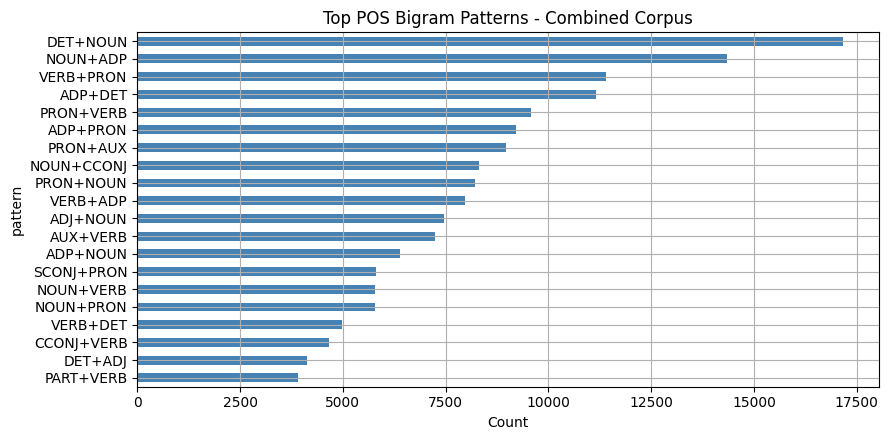

In [9]:
ax = pos_df_combined.plot.barh(x="pattern", y="count", legend=False, color='steelblue')
ax.invert_yaxis()
ax.set_title("Top POS Bigram Patterns - Combined Corpus")
ax.set_xlabel("Count")
# Capture the figure so we can save it later
fig_pos_combined = ax.get_figure()
plt.tight_layout(); plt.show()

### 3.2 Per-Book Comparison

Compare POS patterns across the two works to see if syntactic style differs.

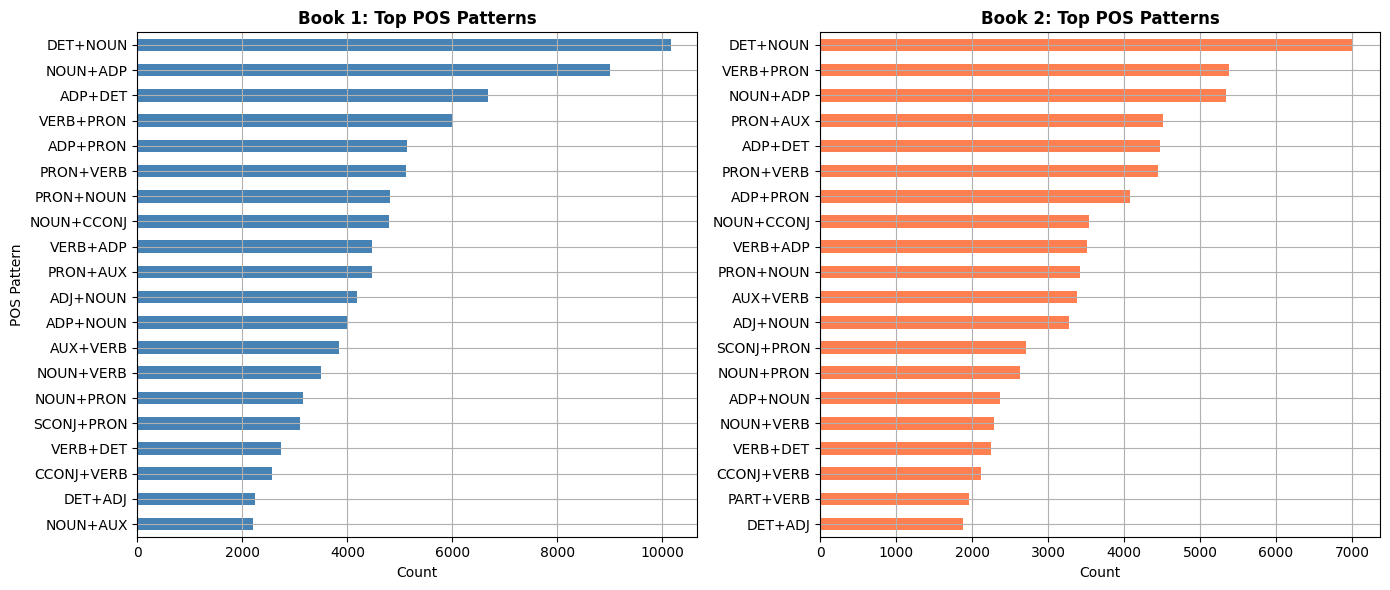

In [10]:
fig_pos_compare, axes = plt.subplots(1, 2, figsize=(14, 6))

# Book 1
ax1 = axes[0]
pos_df_1.plot.barh(x="pattern", y="count", legend=False, color='steelblue', ax=ax1)
ax1.invert_yaxis()
ax1.set_title("Book 1: Top POS Patterns", fontsize=12, fontweight='bold')
ax1.set_xlabel("Count")
ax1.set_ylabel("POS Pattern")

# Book 2
ax2 = axes[1]
pos_df_2.plot.barh(x="pattern", y="count", legend=False, color='coral', ax=ax2)
ax2.invert_yaxis()
ax2.set_title("Book 2: Top POS Patterns", fontsize=12, fontweight='bold')
ax2.set_xlabel("Count")
ax2.set_ylabel("")

plt.tight_layout()
plt.show()

## 4. Notes

- Useful patterns: `ADJ+NOUN`, `NOUN+NOUN`, `VERB+NOUN`, `PRON+VERB`.
- The notebook now analyzes POS patterns for both books individually and for the combined corpus.
- Compare the per-book visualizations to identify syntactic style differences between the two works.

### Interpretation Tips

Comparing POS patterns across works by the same author can reveal:

1. **Stylistic consistency**: If both books show similar POS pattern distributions, the author has a consistent syntactic style across works.

2. **Genre or thematic differences**: Variations in patterns like `ADJ+NOUN` vs. `NOUN+NOUN` may reflect different narrative approaches—more descriptive vs. more action-oriented writing.

3. **Character-driven vs. narration-driven prose**: Higher `PRON+VERB` counts suggest dialogue-heavy or character-focused sections, while `ADJ+NOUN` dominance indicates descriptive narration.

4. **Syntactic complexity**: The diversity and distribution of patterns can indicate sentence structure complexity—varied patterns suggest more sophisticated syntax.

5. **Temporal evolution**: If the books were written at different times, pattern differences may reflect the author's stylistic development or changing literary influences.

For example, if Book 1 shows more `ADJ+NOUN` patterns while Book 2 has more `VERB+NOUN`, this might suggest a shift from descriptive to action-oriented writing style.


## 5. Reflection (Answer in your repo's README or below)

- Which results matched your reading intuition?
- What surprised you?
- If you toggled preprocessing (stopwords on/off), what changed?
- Compare across the two works: are the patterns stable?

## 6. Export (tables/figures)

This cell saves outputs into the `../results/` folder so you can add them to your report.


In [11]:
Path("../results").mkdir(exist_ok=True)

# Save CSV tables
pos_df_combined.to_csv("../results/POS_patterns_combined.csv", index=False)
pos_df_1.to_csv("../results/POS_patterns_book1.csv", index=False)
pos_df_2.to_csv("../results/POS_patterns_book2.csv", index=False)

# Save figures
saved_files = []
try:
    fig_pos_combined.savefig("../results/POS_patterns_combined.png", dpi=200, bbox_inches="tight")
    saved_files.append("POS_patterns_combined.png")
except NameError:
    pass

try:
    fig_pos_compare.savefig("../results/POS_patterns_comparison.png", dpi=200, bbox_inches="tight")
    saved_files.append("POS_patterns_comparison.png")
except NameError:
    pass

if saved_files:
    print(f"✓ Saved CSV tables and figures to ../results/:")
    print(f"  - POS_patterns_combined.csv, POS_patterns_book1.csv, POS_patterns_book2.csv")
    print(f"  - {', '.join(saved_files)}")
else:
    print("⚠ Figures not saved - run the visualization cells first")

✓ Saved CSV tables and figures to ../results/:
  - POS_patterns_combined.csv, POS_patterns_book1.csv, POS_patterns_book2.csv
  - POS_patterns_combined.png, POS_patterns_comparison.png
